# Introduction
This Notebook contains my work for analyzing a 100km transect in the Southern Ocean. The goal is to identify Lee waves from the measurements and then estimate the energy fluxes and transport driven by these lee waves. For some of the more standard plots such as transect contours, I also experiment with my Ocean Toolbox package.

### CURRENT NOTES/QUESTIONS/TO-DO:
* **UPDATE**: **10/1/18 - After speaking with alberto I went back and changed the way that I am doing potential energy calculations and now the wavenumbers are much smaller (roughly 10-15 km) which makes way more sense. This was change from using adiabatic leveling for a reference density to using neutral density (CSIRO CODES) and differencing over a 400 m vertical window.**


* Playing around with the integration limits seems to not change the energy or frequency too much but the horizontal wavelengths do seem sensitive to it.

    * The Lower half of the transect seems to be dominated by an order of magnitude larger wavelengths
    
* If I want to do the energy flux and ray tracing, I think I will pick a couple select packets and isolate them to get more concrete wavenumbers to use in ray tracing.


* Can I use ray tracing to show how energy is trnasported vs dissipated as the wave travels?


* There is realy strong surface shear in half the profile (1st half) and it seems like that is stopping waves (or causing them to break not really sure. Also , if vertical wavenumber increases with flow and horizontal wavenumber decreases, what effect does that have on the wave as a whole?


**The peaks in internal energy visually correlate well with the velocity anamoly graphs where theres packets of similar anomalies. However, I am not sure why the wave numbers are so big (>100km).**


* Check whether lee waves can actually form over such big sizes


* All the frequencies are near f. (should be vertically propogating energy (but much slower in the vertical compared to the horizontal because low vertical group speed. 


* Doppler shift the frequencies to see what happens. 





In [82]:
# Load Data and relevant modules - this is common to both wayss
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd
import internal_waves_calculations as iwc
import warnings
import cmocean
import matplotlib.colors as colors
import ray_tracing as rt
# Probably Shouldn't do this but they annoy me
warnings.simplefilter("ignore")

pd.options.display.max_rows = 3000
pd.options.display.max_columns = 22

plt.rcParams.update({'font.size':14})


# load data and cut off bottom (its all nans)
ladcp, ctd = data_load.load_data()
strain = np.genfromtxt('strain.csv', delimiter=',')
wl_max = 1000
wl_min = 400
ctd_bin_size = 1024
ladcp_bin_size = 1024
nfft = 1024
U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
rho = gsw.density.rho(S, T, p_ctd)

maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth


S = S[idx_ctd,:]
T = T[idx_ctd,:]
rho = rho[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]


# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids (For plots)
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)

**Isopycnal displacements using neutral density from CSIRO matlab function**
* Use a reference buoyancy frequency profile constructed from adiabtic leveling function **SUPER SLOW FUNCTION**
* reference density profile is constructed by fitting a sliding 2nd order polynomial to vertical profiles. 


In [6]:
N2_ref, N2, strain, p_mid, rho_bar = oc.adiabatic_level(S,
                                                        T,
                                                        p_ctd,
                                                        lat,
                                                        pressure_range=400, # Difference window for leveling
                                                        order=1, # order of fit
                                                        axis=0, 
                                                        )
# Neutral Densities
rho_neutral =  np.genfromtxt('neutral_densities.csv', delimiter=',')
rho_n = rho_neutral[idx_ctd,:]

# Poly fit to neutral density to get reference profiles
ref = []

for cast in rho_n.T:
    fitrev = oc.vert_polyFit2(cast, p_ctd[:, 0], 100, deg=2)
    ref.append(fitrev)

ref = np.vstack(ref).T

ref = np.nanmean(ref, axis=1)
ref2 = np.tile(ref,(21,1)).T
eta = oc.isopycnal_displacements(rho_n, ref2, p_ctd, lat)


# Extracting Wave Components
This section uses spectral analysis to estimate kinetic and potential energies lee waves. Using a minimum and maximum vertical wavelength as integration limits, I estimate the energetics of target wavelengths. These limits were determined qualitatively by estimative vertical size of features in profiles (how big are the wiggles). 

## Internal Energy
The wave components are estimated through calcuation of the internal wave energy components (Kinetic and Potential). To do this, each profile is seperated into mean and wave-induced perturbations $(X = X + X')$. In order to do this a sliding vertical polynomial is fit to each profile and the resultant profile is subtracted out, leaving the perturbation profile.

### Kinetic Energy
The resultant velocity perturbation profiles (u and v) are binned into 1024 meter, half overlapping bins. The Power Spectral Density is calculated along each being and integrated between a target wavelength band. This band is chosen by examining the perturbation profiles and identifying coherent wave features. The final values are input into the kinetic energy equation. $\langle \rangle$ denotes integrated power spectral density. 

$$ KE = \frac{1}{2}\big[ \langle u'^{2} \rangle + \langle v'^{2} \rangle \big] $$

### Potential Energy 
A similar process is followed for estimating potential energy. However, 2 methods were implemented here, with varying results. The first was to estimate the isopycnal displacement $\eta$ from density perturbations as follows: 

$$\eta = \frac{\rho - \rho_{ref}}{\frac{\Delta \rho_{ref}}{\Delta z}}$$
            
$\rho_{ref}$ is estimated as a transect mean density profile. See **Potential Energy Notebook for this clalculation worked out**
Once $\eta$ is obtained, the same processes for calculating Power Spectral Density used in kinetic energy calculations are used here with the potential energy equation:

$$ PE = \frac{1}{2}N^2\langle \eta'^{2} \rangle $$

The energy components are combined for the total internal energy $(\frac{J}{m^s})$:

$$ E = \rho_{0}(KE + PE) $$

### Frequency and Horizontal Wavenumber
Using the two energy components, the internal wave frequencies are estimated by:

$$ \omega_{0} = f\sqrt{\frac{KE + PE}{KE - PE}}$$

Several other derivations are used and compared with similar results. An issue with this method is that when kinetic and potential energies are similar, error in energy density calculations may cause kinetic energy to be slightly less than potential, resulting in a null value from the square root operation. 
We now have the intrinsic frequency as well as the vertical waveumnber $m$ which is estimated as the mean of integration limits. From here, $k_{h}$, the horizontal wave number is calculated from:

$$  k_{h} = m\sqrt{\frac{f^2 - \omega^2}{\omega^2 - N^2}}  $$  (Meyer 2016)



In [30]:
# set integration limits by vertical wavelength 
wl_max = 1000
wl_min = 500
# Calculate KE spectrums (m2/s2)
z_ladcp = -1*gsw.z_from_p(p_ladcp, lat)
KE, KE_grid, KE_psd, Uprime, Vprime, ke_peaks = iwc.KE_UV(U, V, z_ladcp, ladcp_bins,
                                                    wl_min, wl_max, lc=wl_min-50,
                                                    nfft=1024, detrend='constant')


# Calculate PE spectrum using eta from above (m2/s2)
z_ctd = -1*gsw.z_from_p(p_ctd, lat)
PE, PE_grid, eta_psd, N2mean, pe_peaks = iwc.PE(N2, z_ctd, eta,
                                                wl_min, wl_max,
                                                ctd_bins, nfft=1024,
                                                detrend='constant')

## Energy Spectrum Plots

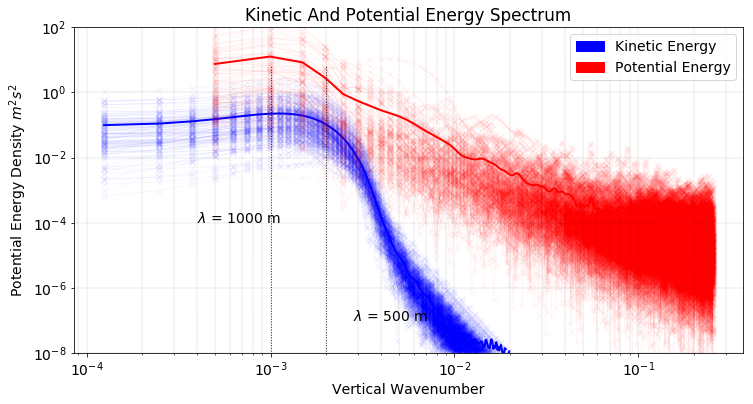

In [31]:
m_plot = np.array([(1)/wl_max,
                       (1)/wl_max, (1)/wl_min,
                       (1)/wl_min])
plt.figure(figsize=[12,6])

plt.loglog(KE_grid, KE_psd.T, linewidth=.6, c='b', marker='x', alpha=.05)
plt.loglog(KE_grid, np.nanmean(KE_psd, axis=0).T, lw=2, c='b')
ylims = plt.gca().get_ylim()
ylim1 = np.array([ylims[0], ylims[1]])
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
plt.ylabel('Kinetic Energy Density')
plt.xlabel('Vertical Wavenumber')
plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)

plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T,
           lw=.6, c='r', marker='x', alpha=.05)
plt.loglog(PE_grid, .5*np.nanmean(N2)*np.nanmean(eta_psd, axis=0).T,
           lw=2, c='r')
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim((1e-8, 1e2))
# plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)
plt.ylabel(r'Potential Energy Density $m^2s^2$')
plt.xlabel('Vertical Wavenumber')
plt.title('Kinetic And Potential Energy Spectrum')
# plt.xlim(.0005, .01)
ax = plt.gca()
plt.text(4e-4, 1e-4,r'$\lambda$ = {} m'.format(wl_max))
plt.text(2.8e-3, 1e-7,r'$\lambda$ = {} m'.format(wl_min))
potential = mpatches.Patch(color='red', label='Potential Energy')
kinetic = mpatches.Patch(color='b', label='Kinetic Energy')
plt.legend(handles=[kinetic, potential])



### Notes:
1. Playing around with the integration limits seems to not change the energy or frequency too much but the horizontal wavelengths do seem sensitive to it.  
2. If I want to do the energy flux and ray tracing, I think I will pick a couple select packets and isolate them to get more concrete wavenumbers to use in ray tracing. 
3. Can I use ray tracing to show how energy is trnasported vs dissipated as the wave travels? 
4. There is realy strong surface sher in half the profile (1st half) and it seems like that is stopping waves (or causing them to break not really sure. Also , if vertical wavenumber increases with flow and horizontal wavenumber decreases, what effect does that have on the wave as a whole?



## Decompose Horizontal Wave Vector
In order to properly run a ray tracing model, the horizontal wavenumber $k_h$ must be decomposed into its two components, $k$ and $l$. The horizontal azimuth, $\theta$, is the angle between the $k_h$ vector and the x-axis. using the relationships:
$$ tan(2\theta) = 2\mathbb{R} \bigg [\frac{u'^{*}v'}{u'u^{*} - v'v^{*}} \bigg ]$$

$$ k = (kh)cos(\theta) $$
$$ l = (kh)sin(\theta) $$

where $*$ represents the complex conjugate and $u'$ and $v'$ represent the Fourier transform of velocity anomalies. 
Fourier transforms are done along the same bins used in the energy calculations. **NOT SO SURE ABOUT HOW RIGHT THIS IS **



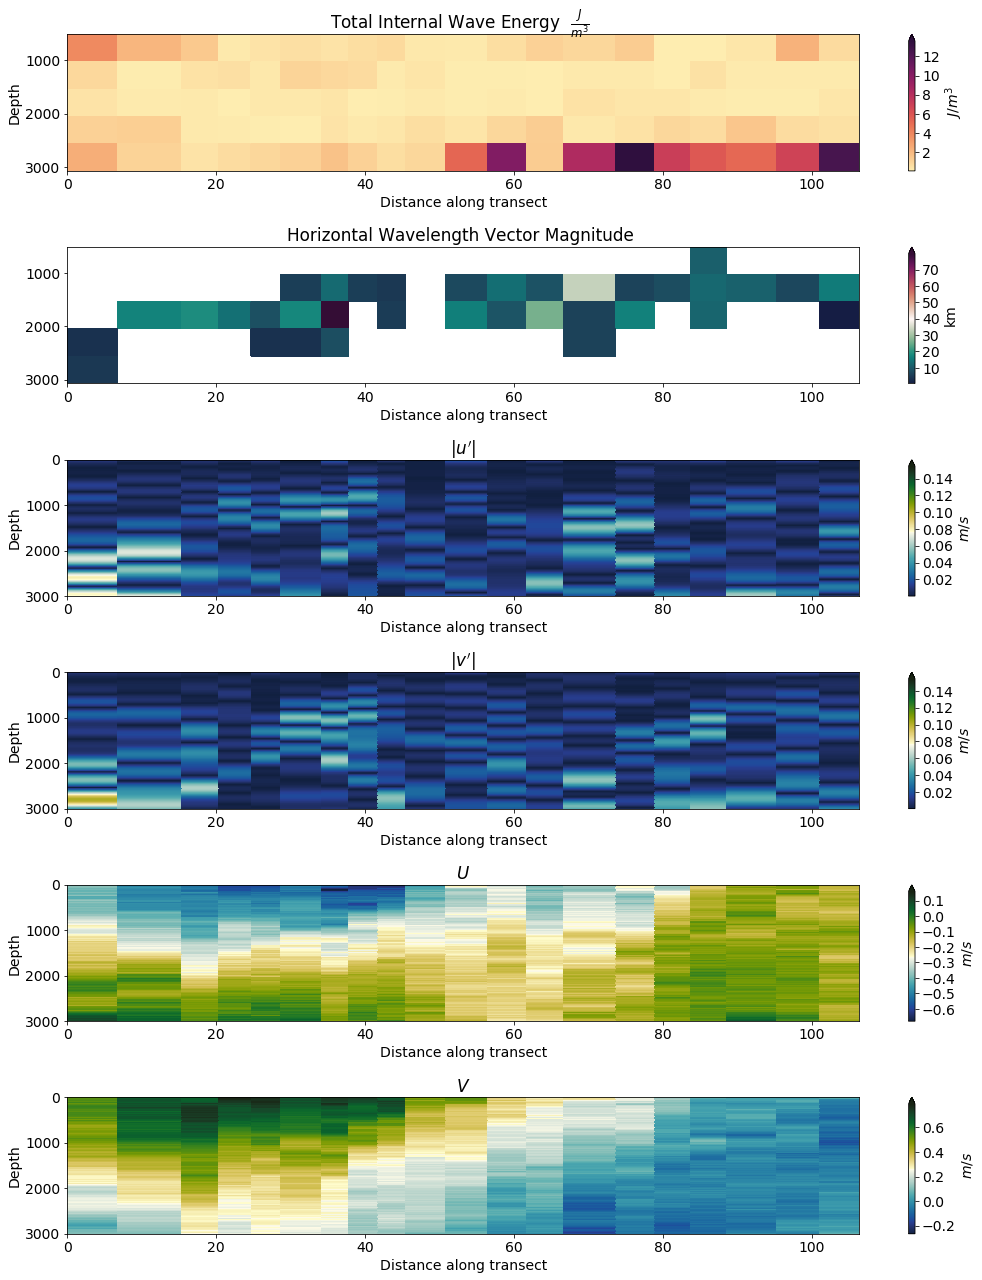

In [78]:
# ENERGY AND WAVE COMPONENT PLOTS
Etotal = 1027*(KE + PE) # Multiply by density to get Joules
# wave components
f = np.nanmean(gsw.f(lat))

# version 2 omega calculation - where did this come from?
omega = f*np.sqrt(((KE+PE)/(KE-PE))) # Waterman et al. 2012 (Ithink)

# m = (2*np.pi)/800

m = (2*np.pi)*np.nanmean(ke_peaks, axis=1)
m = np.reshape(m, KE.shape, order='F') 


kh = m*np.sqrt(((f**2 - omega**2)/(omega**2 - N2mean))) # Waterman et al. 2012
kh2 = (m/np.sqrt(N2mean))*(np.sqrt(omega**2 - f**2)) # Where (meyer i think?)

lambdaH = 1e-3*(2*np.pi)/kh
lambdaH2 = 1e-3*(2*np.pi)/kh2

# version 2 omega calculation
Rw = KE/PE # Unsure what to do with this just yet. 

# Wave vector decomposition
k = []
l = []

theta = []
dz = 8

for i in ladcp_bins:
    theta.append(iwc.horizontal_azimuth(Uprime[i,:], Vprime[i,:], dz,\
                                        wl_min=wl_min,
                                        wl_max=wl_max,
                                        nfft=1024))
theta = np.vstack(theta)

k = kh*np.cos(theta)
l = kh*np.sin(theta)

plt.figure(figsize=[15,18])
plt.subplot(611)
plt.pcolormesh(dist.flatten(), depths.flatten(), (Etotal), cmap=cmocean.cm.matter)
c1 = plt.colorbar(extend='max')
c1.set_label(r'$J/m^3$')
plt.gca().invert_yaxis()
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r'Total Internal Wave Energy  $\frac{J}{m^{3}}$  ')

mask = lambdaH > 150
norm=colors.LogNorm(vmin=lambdaH.min(), vmax=lambdaH.max())

# lambdaH[mask] = np.nan
plt.subplot(612)
plt.pcolormesh(dist.flatten(), depths.flatten(), (lambdaH), cmap=cmocean.cm.curl, norm=None)
c2 = plt.colorbar(extend='max')
c2.set_label(r'km')
plt.gca().invert_yaxis()
plt.xlabel('Distance along transect')
plt.title('Horizontal Wavelength Vector Magnitude ')


plt.subplot(613)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), np.abs(Uprime), cmap=cmocean.cm.delta)
c3 = plt.colorbar(extend='max')
c3.set_label(r'$m/s$')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$|u'|$")
plt.ylim(0,3000)
plt.gca().invert_yaxis()

plt.subplot(614)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), np.abs(Vprime), cmap=cmocean.cm.delta)
c3 = plt.colorbar(extend='max')
c3.set_label(r'$m/s$')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$|v'|$")
plt.ylim(0,3000)
plt.gca().invert_yaxis()
plt.tight_layout()

plt.subplot(615)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), U, cmap=cmocean.cm.delta, shading='flat')
c3 = plt.colorbar(extend='max')
c3.set_label(r'$m/s$')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$U $")
plt.ylim(0,3000)
plt.gca().invert_yaxis()
plt.tight_layout()

plt.subplot(616)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), V, cmap=cmocean.cm.delta, shading='flat')
c3 = plt.colorbar(extend='max')
c3.set_label(r'$m/s$')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$V $")
plt.ylim(0,3000)
plt.gca().invert_yaxis()
plt.tight_layout()


![title](velocity_anomalies.png)

In [76]:
# # Experiment with peaks and see what happens  KINDA USELESS CODE BUT INTERESTING TO LOOK AT

# # split u and v peaks (they come together as output of the kinetic energy function)
# u_peaks = ke_peaks[:,0]
# v_peaks = ke_peaks[:,1]

# # Reshape the arrays to match the binned grids 
# # fortran order reshapes it the right way ( I was to lazy to do it earlier)
# u_peaks = np.reshape(u_peaks, KE.shape, order='F') 

# oc.display(u_peaks, index=depths.flatten())

# mask = 1/u_peaks > 1700
# u_peaks[mask] = np.nan
# plt.figure(figsize=[20,20])
# ax = plt.gca()
# ax.matshow(u_peaks)




# for (i, j), z in np.ndenumerate(1/u_peaks):
#     ax.text(j, i, '{:0f}'.format(z), ha='center', va='center',
#             bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))


# # plt.pcolormesh(dist.flatten(), depths.flatten(), 1/u_peaks, cmap=cmocean.cm.matter)
# # c1 = plt.colorbar(extend='max')
# # c1.set_label(r'$J/m^3$')
# # plt.gca().invert_yaxis()
# # plt.xlabel('Distance along transect')
# # plt.ylabel('Depth')
# # plt.title(r'Total Internal Wave Energy  $\frac{J}{m^{3}}$  ')



### Notes:
The peaks in internal energy visually correlate well with the velocity anamoly graphs where theres packets of similar anomalies. However, I am not sure why the wave numbers are so big (>100km).
* Check whether lee waves can actually form over such big sizes
* All the frequencies are near f. (should be vertically propogating energy (but much slower in the vertical compared to the horizontal because low vertical group speed. 
* Doppler shift the frequencies to see what happens. 



In [101]:
table = oc.display(omega, index=depths.flatten())
table.style.set_caption('Horizontal Wavelength V1')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.000248361,nan,nan,nan,nan
1024.0,nan,nan,nan,nan,nan,-0.000252925,-0.000149151,-0.00025356,-0.000370069,nan,-0.000178712,-0.000151675,-0.000202763,-0.000122448,-0.00029483,-0.000221284,-0.00015324,-0.000159159,-0.000237854,-0.000164063,nan
1536.0,nan,-0.000159551,-0.00013848,-0.000132755,-0.000155963,-0.000134383,-0.000118599,nan,-0.000238573,nan,-0.00014108,-0.000147857,-0.000128454,-0.000198269,-0.000131392,nan,-0.000163171,nan,nan,-0.00122463,nan
2048.0,-0.000284854,nan,nan,nan,-0.000253154,-0.000317431,-0.000177377,nan,nan,nan,nan,nan,nan,-0.000242507,nan,nan,nan,nan,nan,nan,nan
2560.0,-0.000218496,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3072.0,nan,nan,nan,nan,nan,nan,nan,-0.000138959,-0.000118403,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


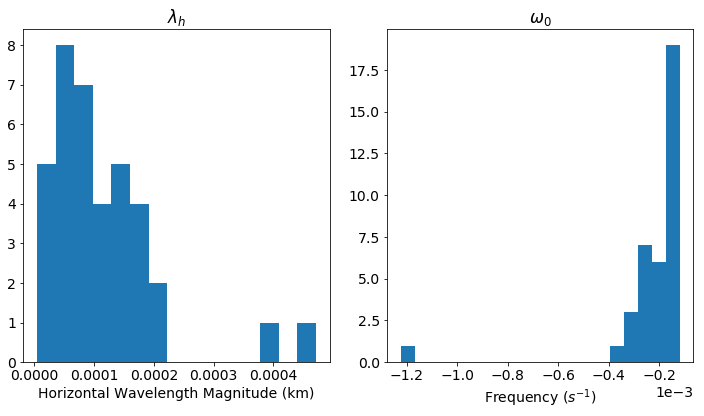

In [71]:
fig = plt.figure(figsize=[10,6])
plt.subplot(121)
plt.hist(lambdaH.flatten(), bins=15, range=(np.nanmin(lambdaH), np.nanmax(lambdaH)))
plt.title(r'$\lambda_h$')
plt.xlabel(r'Horizontal Wavelength Magnitude (km)')
plt.tight_layout()

plt.subplot(122)
plt.hist(omega.flatten(), bins=20, range=(np.nanmin(omega), np.nanmax(omega)))
plt.title(r'$\omega_0$')
plt.xlabel(r'Frequency ($s^{-1}$)')
plt.tight_layout()
ax = plt.gca()
ax.ticklabel_format(style='sci', scilimits=(1,1), axis='x')



In [175]:
table = oc.display(k, index=depths.flatten())
table.style.set_caption(r'Horizontal Wavenumber $k$')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000605091,nan,nan,nan,nan
1024.0,nan,nan,nan,nan,nan,0.000933967,0.000364658,0.000722037,0.0014705,nan,0.000550291,0.000371264,0.000637666,0.000140302,0.00106354,0.000807314,0.000421943,0.000439175,0.000791689,0.000395655,nan
1536.0,nan,0.00060815,0.000416063,0.000324448,0.000483114,0.00036987,9.99836e-05,nan,0.000919908,nan,0.000328157,0.000404802,0.000294038,0.000902956,0.000259641,nan,0.000639302,nan,nan,0.0127165,nan
2048.0,0.00179689,nan,nan,nan,0.00123446,0.00209607,0.000865104,nan,nan,nan,nan,nan,nan,0.00146897,nan,nan,nan,nan,nan,nan,nan
2560.0,0.0012584,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3072.0,nan,nan,nan,nan,nan,nan,nan,0.000668969,0.000169698,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [176]:
table = oc.display(l, index=depths.flatten())
table.style.set_caption(r'Horizontal Wavenumber $l$')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.08014e-05,nan,nan,nan,nan
1024.0,nan,nan,nan,nan,nan,-0.000246738,0.000155967,-0.000646445,-0.000419184,nan,0.000181619,0.000182792,0.00031482,6.86718e-05,-0.000487069,-1.33213e-05,4.45275e-05,0.000145409,-0.000409205,-0.000294365,nan
1536.0,nan,5.26736e-05,-2.48425e-05,-0.000139543,0.000321361,-4.05131e-05,5.28106e-05,nan,-0.000736463,nan,-0.000298309,0.000307793,-5.37247e-05,-2.51011e-05,0.00021443,nan,-3.2474e-05,nan,nan,0.00545231,nan
2048.0,-0.000348978,nan,nan,nan,-0.000972641,2.52641e-05,0.000318729,nan,nan,nan,nan,nan,nan,0.000210573,nan,nan,nan,nan,nan,nan,nan
2560.0,0.000725072,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3072.0,nan,nan,nan,nan,nan,nan,nan,0.000169664,-3.72118e-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [100]:
table = oc.display(m, index=depths.flatten())
table.style.set_caption(r'Horizontal Wavenumber $m$')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,0.00976433,0.00937375,0.0117172,0.00898318,0.00507745,0.00820204,0.0124983,0.00976433,0.00781146,0.00820204,0.00937375,0.00898318,0.0105455,0.00976433,0.00898318,0.00976433,0.00703032,0.00898318,0.00781146,0.00898318,0.0113266
1024.0,0.00859261,0.0113266,0.00898318,0.00781146,0.0105455,0.00859261,0.00937375,0.00859261,0.00663974,0.0101549,0.010936,0.00859261,0.00742089,0.00937375,0.00624917,0.00742089,0.00898318,0.00898318,0.00742089,0.00624917,0.00663974
1536.0,0.00663974,0.00468688,0.00624917,0.00976433,0.00937375,0.00742089,0.00546802,0.00312458,0.00742089,0.00742089,0.00663974,0.0101549,0.00624917,0.00859261,0.00859261,0.00663974,0.00624917,0.000781146,0.00820204,0.00781146,0.00742089
2048.0,0.00742089,0.00703032,0.00507745,0.00663974,0.00859261,0.00624917,0.00624917,0.00663974,0.00820204,0.00898318,0.00781146,0.00663974,0.00703032,0.00507745,0.00820204,0.00703032,0.00390573,0.00546802,0.00742089,0.00937375,0.00859261
2560.0,0.00703032,0.00507745,0.00663974,0.00859261,0.00820204,0.00546802,0.00546802,0.00859261,0.00703032,0.0058586,0.00703032,0.00663974,0.00781146,0.00820204,0.00937375,0.00546802,0.0058586,0.0058586,0.00663974,0.00781146,0.00663974
3072.0,0.00859261,0.00663974,0.0058586,0.00820204,0.0101549,0.00546802,0.00742089,0.00546802,0.00312458,0.00624917,0.00390573,0.00390573,0.00781146,0.00703032,0.00781146,0.00468688,0.00624917,0.00624917,0.0136701,0.00663974,0.00390573


### Ray Tracing
Ray tracing equations are following Olbers 1981 as follows:

Horizontal Group Speeds:
$$ C_{gx} = k\frac{N^2 - \omega^2}{\omega(kh^2 + m^2)} $$
$$ C_{gy} = l\frac{N^2 - \omega^2}{\omega(kh^2 + m^2)} $$
Vertical Group Speed:
$$ C_{gz} = m\frac{\omega^2 - f^2}{\omega(kh^2 + m^2)} $$
Change in vertical wavenumber:
$$ \frac{dm}{dt} \approx \frac{dm}{dz} = -\big (k\frac{du}{dz} + l\frac{dv}{dz} \big) $$

Group speeds are multiplied by the specified time step to get x, y, z movements. horizontal wavenumber components are assumed constant (for now). Vertical wavenumber changes with depth (velocity and buoyancy profiles are constant in x,y, and time.

In [104]:
l1 =  -0.000139543
k1 = 0.000324448
m1 = -0.00976433
z0 = 1500
w0 = -0.000132755
wave1 = rt.wave(k=k1, l=l1, m=m1, w0=w0, z0=z0)

# check that the properties are loaded correctly by using the properties attribute
wave1.properties()

Wave Properties:
---------------
    k: [ 0.00032445]
    l: [-0.00013954]
    m: [-0.00976433]
    kh: [[ 0.00035318]]
    Frequency: [-0.00013275]




Ray Tracing Report:
-------------------
X-Distance: [ 63.2880421] km
Y-Distance: [-43.66570331] km
Z-Distance: [ 2456.02517698] m
Duration: 172800 seconds
Time Step: 10.0 seconds
Hit Sea Floor : NO



Text(0.5,1,'Ray Tracing - Run Duration: 48 hours')

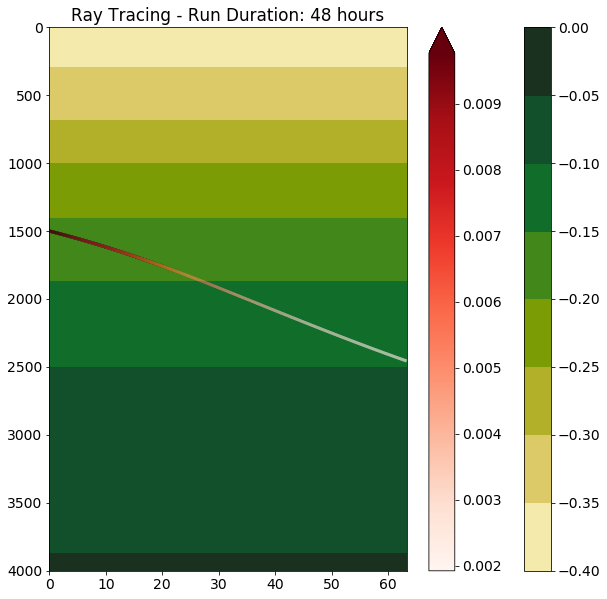

In [111]:
duration = 48
tstep = 10
status = 6 # intervals to give run status
wave1.back3d(duration=duration, tstep=tstep, status=status, print_run_report=True)
fig1 = plt.figure(figsize=[10,10])
wave1.x_m_plot(fig=fig1, cmap='Reds', line_colorbar=True)
plt.title('Ray Tracing - Run Duration: {} hours'.format(duration))

### Ray Tracing Experiments
Using the wave component estimates from above, ray tracing is run for each bin value.

#### Notes and Observations:
* 

In [98]:
depths2 = np.tile(depths, (21,1))
seafloor = 4000
status = False

waves = []
for i in range(KE.flatten().shape[0]):
    if np.sum(np.isfinite([k.flatten()[i], l.flatten()[i], m.flatten()[i], omega.flatten()[i]])) == 4:
        waves.append(rt.wave(k=k.flatten()[i],
                        l=l.flatten()[i], m=-m.flatten()[i],
                        w0=omega.flatten()[i], z0=depths2.flatten()[i]))
duration = 48
tstep = 10
status = 6 
seafloor = 4000
for wave in waves:
    wave.back3d(duration=duration, tstep=tstep,
                status=status, seafloor=seafloor, 
                updates=False, print_run_report=False)
    

Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor
Wave ray hit seafloor


Text(0.5,0,'x - Distance (km) ')

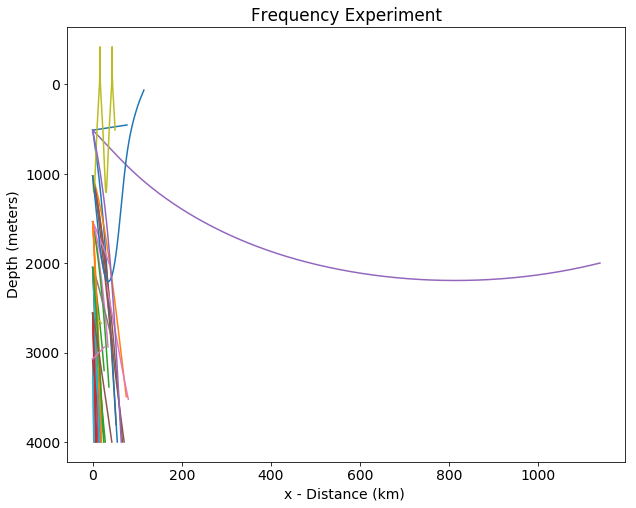

In [99]:
# Plot ray tracing (Cell is split to make plot changes without having to re run the model)
plt.figure(figsize=[10,8])
for wave in waves:
    plt.plot(wave.x_ray.flatten(), wave.z_ray.flatten(), label=r'$\omega$ = {}'.format(wave.w0_init))

  
plt.gca().invert_yaxis()
plt.title('Frequency Experiment')
plt.ylabel('Depth (meters)')
plt.xlabel('x - Distance (km) ')

## Dissipation rate calculation - Thorpe Scales
Thorpe scales are used to estimate the local dissipation rate, which will be compared to the estimated dissipation rate of the obeserved internal waves. For each bin, the density profile is resorted into monotonic order and the root mean square of the vertical displacements is calculated as the Thorpe Scale. This length scale is related empirically to the dissipation rate following the work of [@Meter et al. 2015]. 



(126, 1)

nan